# **1 - Environment setup**




In [1]:
!python --version

Python 3.7.11


In [2]:
!pip install --upgrade imgaug

     |████████████████████████████████| 948 kB 9.6 MB/s 
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.4.0 which is incompatible.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from PIL import Image
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import shutil
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
import random
import imgaug.augmenters as iaa
from tensorflow.keras.utils import Sequence
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.losses import CategoricalCrossentropy
import time
from datetime import datetime

# **2 - utilities**

In [5]:
def create_mask(img,cats):
    '''creates an mask from image and segmentation categories
    
    Args:
      img - PIL image
      cats - dict {'cat1':[value1,value2,value3,etc...],'cat2':[value1,value2,value3,etc...]}
    
    Returns:
      A mask of type np.array of dimension (shape(img),len(cats)) '''
    
    
    img =tf.keras.preprocessing.image.img_to_array(img,dtype=np.int32) # convert img to np.array
    img=np.squeeze(img) #remove 1 dimension
    mask = np.zeros((img.shape[0], img.shape[1], len(cats)),dtype=int) # create a mask with zeros
    flat_cat = [val for cat in list(cats.values()) for val in cat] # create a list of all values associated with categories
    ca_min=min(flat_cat)
    ca_max=max(flat_cat)
    cats_names=list(cats.keys())
    
    #for each values associated with a category, fill in the mask with the corresponding category number
    for i in range(ca_min,ca_max):
            for idx,name in enumerate(cats_names):
                if i in cats[name]:
                    mask[:,:,idx] = np.logical_or(mask[:,:,idx],(img==i))
    return mask


def generate_img_from_mask(mask,cats,colors_palette=['b','g','r','c','m','y','k','w']):
    
    '''Generate a PIL image from a segmented mask and categorie cats with specified color palette for each cateorie
    
    Args:
      mask - numpy array of dimension (shape(img),len(cats))
      cats - dict {'cat1':[value1,value2,value3],'cat2':[value1,value2,value3]}
    
    Returns
      PIL image'''
    img_seg = np.zeros((mask.shape[0],mask.shape[1],3),dtype='float')
    for cat in range(len(cats)):
        img_seg[:,:,0] += mask[:,:,cat]*colors.to_rgb(colors_palette[cat])[0]
        img_seg[:,:,1] += mask[:,:,cat]*colors.to_rgb(colors_palette[cat])[1]
        img_seg[:,:,2] += mask[:,:,cat]*colors.to_rgb(colors_palette[cat])[2]
        
    return tf.keras.preprocessing.image.array_to_img(img_seg)  

def normalize_input_img(img):
    '''Normalize PIL image to fall in [-1,1] range, returns 3D numpy array'''
    img =tf.keras.preprocessing.image.img_to_array(img,dtype=np.int32)
    img = img/127.5
    img -= 1
    return img

def get_concat_h(im1, im2):
    
    '''concatenate two PIL images horizontaly'''
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst


def show_results(img,mask,model):
    
    '''concatenates the img, the reference mask and the predicted mask'''

    img_norm = np.array(normalize_input_img(img))
    
    img_pred = model.predict(img_norm.reshape(1,128,256,3))[0]
    
    res = get_concat_h(get_concat_h(img,generate_img_from_mask(create_mask(mask,cats),cats)),generate_img_from_mask(img_pred,cats))
    
    return res

#**3 - Dataset**

In [6]:
colors_palette=['black','purple','grey','yellow','forestgreen','skyblue','red','mediumblue']
cats = {'void': [0, 1, 2, 3, 4, 5, 6],
 'flat': [7, 8, 9, 10],
 'construction': [11, 12, 13, 14, 15, 16],
 'object': [17, 18, 19, 20],
 'nature': [21, 22],
 'sky': [23],
 'human': [24, 25],
 'vehicle': [26, 27, 28, 29, 30, 31, 32, 33, -1]}

In [7]:
image_train_path="/content/drive/MyDrive/light_def/images/train"
mask_train_path="/content/drive/MyDrive/light_def/masks/train"

image_test_path="/content/drive/MyDrive/light_def/images/test"
mask_test_path="/content/drive/MyDrive/light_def/masks/test"

image_val_path="/content/drive/MyDrive/light_def/images/val"
mask_val_path="/content/drive/MyDrive/light_def/masks/val"

In [8]:
image_train_filename = os.listdir(image_train_path)
mask_train_filename = os.listdir(mask_train_path)
image_train_filename.sort()
mask_train_filename.sort()

image_test_filename = os.listdir(image_test_path)
mask_test_filename = os.listdir(mask_test_path)
image_test_filename.sort()
mask_test_filename.sort()



image_val_filename = os.listdir(image_val_path)
mask_val_filename = os.listdir(mask_val_path)
image_val_filename.sort()
mask_val_filename.sort()


In [9]:
len(image_train_filename)

2975

In [10]:
len(image_test_path)

44

In [11]:
len(image_val_path)

43

# **4 - Datagenerators & augmentation**

In [12]:
def blur_img(img):
    '''Add random blur to image, returns PIL image'''
    n = random.uniform(0,2.0) # Generating random value for sigma
    blur_transform = iaa.Sequential([iaa.GaussianBlur(sigma=n)])
    img_blur = blur_transform(image=tf.keras.preprocessing.image.img_to_array(img))

    return tf.keras.preprocessing.image.array_to_img(img_blur)

def zoom_img(img,mask):
    '''Add random zoom to image and mask, returns transformed PIL image and corresponding mask'''
    n = random.uniform(1,5) # Generating random value for sigma
    zoom_transform = iaa.Sequential([iaa.Affine(scale=n,order=0)]) # uses order=0 to avoid artifacts in mask
    img_zoom = zoom_transform(image=tf.keras.preprocessing.image.img_to_array(img))
    mask_zoom = zoom_transform(image=tf.keras.preprocessing.image.img_to_array(mask))

    return tf.keras.preprocessing.image.array_to_img(img_zoom), tf.keras.preprocessing.image.array_to_img(mask_zoom,scale=False)

def brightness_img(img):
    '''Add random brightness to image, returns PIL image'''
    br_transform = iaa.Sequential([iaa.MultiplyBrightness((0.1,2))])
    img_br = br_transform(image=tf.keras.preprocessing.image.img_to_array(img).astype(np.uint8))
    
    return tf.keras.preprocessing.image.array_to_img(img_br,scale=False)

def flip_img(img,mask):
    '''Flips verticaly image, returns transformed PIL image and corresponding mask'''
    flip_transform = iaa.Sequential([iaa.Fliplr()])
    img_flip = flip_transform(image=tf.keras.preprocessing.image.img_to_array(img))
    mask_flip = flip_transform(image=tf.keras.preprocessing.image.img_to_array(mask))

    return tf.keras.preprocessing.image.array_to_img(img_flip), tf.keras.preprocessing.image.array_to_img(mask_flip,scale=False)



In [13]:

class seg_gen(Sequence):
    
    def __init__(self, image_dir,
                 mask_dir,
                 batch_size,
                 img_height,
                 img_width,
                 cats,
                 sample_perc=100,
                 aug_blur=False,
                 aug_zoom=False,
                 aug_brightness=False,
                 aug_flip=False):
        
        self.image_dir = image_dir
        self.mask_dir =  mask_dir
        self.image_filename =  os.listdir(image_dir)
        self.image_filename.sort()
        self.mask_filename =  os.listdir(mask_dir)
        self.mask_filename.sort()
        self.sample_perc = sample_perc
        # Generate a sample
        rdm_index = random.sample(range(0,len(self.image_filename)),int(len(self.image_filename)*self.sample_perc/100))
        image_filename_sample = []
        for i in rdm_index:
            image_filename_sample.append(self.image_filename[i])
            
        mask_filename_sample = [] 
        for i in rdm_index:
            mask_filename_sample.append(self.mask_filename[i])
                
        self.image_filename = image_filename_sample
        self.mask_filename = mask_filename_sample
        
        self.batch_size = batch_size
        self.img_height = img_height
        self.img_width = img_width
        self.cats = cats
        self.sample_perc = sample_perc
        self.aug_blur = aug_blur
        self.aug_zoom = aug_zoom
        self.aug_brightness = aug_brightness
        self.aug_flip = aug_flip

    def __len__(self):
        return int(np.ceil(len(self.image_filename) / float(self.batch_size)))

    def __getitem__(self, idx):
        'generate one batch with random index'
        
        idx = np.random.randint(0,len(self.image_filename)-1, self.batch_size) #generate random index for the batch
        batch_img, batch_mask = [], []
        
        for i in idx:
            
            #filename
            img_file = self.image_dir+'/'+self.image_filename[i] 
            mask_file = self.mask_dir+'/'+self.mask_filename[i]
            
            #Load as PIL image and resize
            img = tf.keras.preprocessing.image.load_img(img_file,target_size=(self.img_height,self.img_width))
            mask = tf.keras.preprocessing.image.load_img(mask_file,target_size=(128,256),color_mode="grayscale")
                        
            #Normalize image and create mask from greyscale image
            img_norm = normalize_input_img(img)
            mask_tensor = create_mask(mask,self.cats)            
          
            #Add to the batch
            batch_img.append(img_norm)
            batch_mask.append(mask_tensor)
            
            #Image augmentation
            if self.aug_blur:
                batch_img.append(normalize_input_img(blur_img(img)))
                batch_mask.append(mask_tensor) # When using blur augmentation,the mask is not changed
            
            if self.aug_zoom:
                zooms = zoom_img(img,mask)
                batch_img.append(normalize_input_img(zooms[0]))
                batch_mask.append(create_mask(zooms[1],self.cats))
             
            if self.aug_brightness:
                batch_img.append(normalize_input_img(brightness_img(img)))
                batch_mask.append(mask_tensor) # When using brightness augmentation,the mask is not changed
            
            if self.aug_flip:
                flips = flip_img(img,mask)
                batch_img.append(normalize_input_img(flips[0]))
                batch_mask.append(create_mask(flips[1],self.cats))            
              
            
        return np.array(batch_img), np.array(batch_mask)

In [14]:
cats = {'void': [0, 1, 2, 3, 4, 5, 6],
 'flat': [7, 8, 9, 10],
 'construction': [11, 12, 13, 14, 15, 16],
 'object': [17, 18, 19, 20],
 'nature': [21, 22],
 'sky': [23],
 'human': [24, 25],
 'vehicle': [26, 27, 28, 29, 30, 31, 32, 33, -1]}

In [15]:
train_gen = seg_gen(image_train_path,mask_train_path,10,128,256,cats,sample_perc=20,aug_blur=True,aug_zoom=True,aug_brightness=True,aug_flip=True)

In [16]:
val_gen = seg_gen(image_val_path,mask_val_path,10,128,256,cats,sample_perc=20,aug_blur=True,aug_zoom=True,aug_brightness=True,aug_flip=True)

In [17]:
batch_img,batch_mask = train_gen.__getitem__(1)

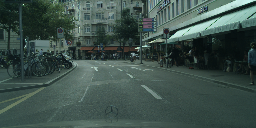

In [18]:
tf.keras.preprocessing.image.array_to_img(batch_img[39])

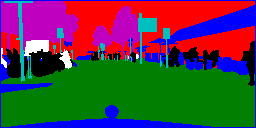

In [19]:
tf.keras.preprocessing.image.array_to_img(generate_img_from_mask(batch_mask[39],cats))

Building FCN-8 Model

# **5 - FCN8 model**

In [28]:
def block(x, n_convs, filters, kernel_size, activation, pool_size, pool_stride, block_name):
  '''
  Defines a block in the VGG network.

  Args:
    x (tensor) -- input image
    n_convs (int) -- number of convolution layers to append
    filters (int) -- number of filters for the convolution layers
    activation (string or object) -- activation to use in the convolution
    pool_size (int) -- size of the pooling layer
    pool_stried (int) -- stride of the pooling layer
    block_name (string) -- name of the block

  Returns:
    tensor containing the max-pooled output of the convolutions
  '''

  for i in range(n_convs):
      x = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size,
                                 activation=activation, padding='same', name="{}_conv{}".format(block_name, i + 1))(x)
    
  x = tf.keras.layers.MaxPooling2D(pool_size=pool_size, 
                                   strides=pool_stride, name="{}_pool{}".format(block_name, i+1 ))(x)

  return x

In [29]:
# https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5
# assign to a variable
vgg_weights_path = "/content/drive/MyDrive/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"

In [30]:
def VGG_16(image_input):
  '''
  This function defines the VGG encoder.

  Args:
    image_input (tensor) - batch of images

  Returns:
    tuple of tensors - output of all encoder blocks plus the final convolution layer
  '''

  # create 5 blocks with increasing filters at each stage. 
  # you will save the output of each block (i.e. p1, p2, p3, p4, p5). "p" stands for the pooling layer.
  x = block(image_input,n_convs=2, filters=64, kernel_size=(3,3), 
            activation='relu',pool_size=(2,2), pool_stride=(2,2), block_name='block1')
  p1= x

  x = block(x,n_convs=2, filters=128, kernel_size=(3,3),
            activation='relu',pool_size=(2,2), pool_stride=(2,2), block_name='block2')
  p2 = x

  x = block(x,n_convs=3, filters=256, kernel_size=(3,3), 
            activation='relu',pool_size=(2,2), pool_stride=(2,2), block_name='block3')
  p3 = x

  x = block(x,n_convs=3, filters=512, kernel_size=(3,3), 
            activation='relu',pool_size=(2,2), pool_stride=(2,2), block_name='block4')
  p4 = x

  x = block(x,n_convs=3, filters=512, kernel_size=(3,3), 
            activation='relu',pool_size=(2,2), pool_stride=(2,2), block_name='block5')
  p5 = x

  # create the vgg model
  vgg  = tf.keras.Model(image_input , p5)

  # load the pretrained weights you downloaded earlier
  vgg.load_weights(vgg_weights_path) 

  # number of filters for the output convolutional layers
  n = 4096

  # our input images are 224x224 pixels so they will be downsampled to 7x7 after the pooling layers above.
  # we can extract more features by chaining two more convolution layers.
  c6 = tf.keras.layers.Conv2D( n , ( 7 , 7 ) , activation='relu' , padding='same', name="conv6")(p5)
  c7 = tf.keras.layers.Conv2D( n , ( 1 , 1 ) , activation='relu' , padding='same', name="conv7")(c6)

  # return the outputs at each stage. you will only need two of these in this particular exercise 
  # but we included it all in case you want to experiment with other types of decoders.
  return (p1, p2, p3, p4, c7)

In [31]:
def fcn8_decoder(convs, n_classes):
  '''
  Defines the FCN 8 decoder.

  Args:
    convs (tuple of tensors) - output of the encoder network
    n_classes (int) - number of classes

  Returns:
    tensor with shape (height, width, n_classes) containing class probabilities
  '''

  # unpack the output of the encoder
  f1, f2, f3, f4, f5 = convs
  
  # upsample the output of the encoder then crop extra pixels that were introduced
  o = tf.keras.layers.Conv2DTranspose(n_classes , kernel_size=(4,4) ,  strides=(2,2) , use_bias=False )(f5)
  o = tf.keras.layers.Cropping2D(cropping=(1,1))(o)

  # load the pool 4 prediction and do a 1x1 convolution to reshape it to the same shape of `o` above
  o2 = f4
  o2 = ( tf.keras.layers.Conv2D(n_classes , ( 1 , 1 ) , activation='relu' , padding='same'))(o2)

  # add the results of the upsampling and pool 4 prediction
  o = tf.keras.layers.Add()([o, o2])

  # upsample the resulting tensor of the operation you just did
  o = (tf.keras.layers.Conv2DTranspose( n_classes , kernel_size=(4,4) ,  strides=(2,2) , use_bias=False ))(o)
  o = tf.keras.layers.Cropping2D(cropping=(1, 1))(o)

  # load the pool 3 prediction and do a 1x1 convolution to reshape it to the same shape of `o` above
  o2 = f3
  o2 = ( tf.keras.layers.Conv2D(n_classes , ( 1 , 1 ) , activation='relu' , padding='same'))(o2)

  # add the results of the upsampling and pool 3 prediction
  o = tf.keras.layers.Add()([o, o2])
  
  # upsample up to the size of the original image
  o = tf.keras.layers.Conv2DTranspose(n_classes , kernel_size=(8,8) ,  strides=(8,8) , use_bias=False )(o)

  # append a softmax to get the class probabilities
  o = (tf.keras.layers.Activation('softmax'))(o)

  return o

In [32]:
def segmentation_model():
  '''
  Defines the final segmentation model by chaining together the encoder and decoder.

  Returns:
    keras Model that connects the encoder and decoder networks of the segmentation model
  '''
  
  inputs = tf.keras.layers.Input(shape=(128,256,3))
  convs = VGG_16(image_input=inputs)
  outputs = fcn8_decoder(convs, 8)
  model = tf.keras.Model(inputs=inputs, outputs=outputs)

  
  return model

In [33]:
# instantiate the model and see how it looks
model_fcn8 = segmentation_model()
model_fcn8.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 128, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 128, 256, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool2 (MaxPooling2D)     (None, 64, 128, 64)  0           block1_conv2[0][0]               
____________________________________________________________________________________________

save initial weights for comparing different trianing strategy

In [34]:
model_fcn8.save_weights('model_fcn8_initial.h5')

#**6 - U-net model**

In [ ]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3):
  '''
  Adds 2 convolutional layers with the parameters passed to it

  Args:
    input_tensor (tensor) -- the input tensor
    n_filters (int) -- number of filters
    kernel_size (int) -- kernel size for the convolution

  Returns:
    tensor of output features
  '''
  # first layer
  x = input_tensor
  for i in range(2):
    x = tf.keras.layers.Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
            kernel_initializer = 'he_normal', padding = 'same')(x)
    x = tf.keras.layers.Activation('relu')(x)
  
  return x


def encoder_block(inputs, n_filters=64, pool_size=(2,2), dropout=0.3):
  '''
  Adds two convolutional blocks and then perform down sampling on output of convolutions.

  Args:
    input_tensor (tensor) -- the input tensor
    n_filters (int) -- number of filters
    kernel_size (int) -- kernel size for the convolution

  Returns:
    f - the output features of the convolution block 
    p - the maxpooled features with dropout
  '''

  f = conv2d_block(inputs, n_filters=n_filters)
  p = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(f)
  p = tf.keras.layers.Dropout(0.3)(p)

  return f, p


def encoder(inputs):
  '''
  This function defines the encoder or downsampling path.

  Args:
    inputs (tensor) -- batch of input images

  Returns:
    p4 - the output maxpooled features of the last encoder block
    (f1, f2, f3, f4) - the output features of all the encoder blocks
  '''
  f1, p1 = encoder_block(inputs, n_filters=64, pool_size=(2,2), dropout=0.3)
  f2, p2 = encoder_block(p1, n_filters=128, pool_size=(2,2), dropout=0.3)
  f3, p3 = encoder_block(p2, n_filters=256, pool_size=(2,2), dropout=0.3)
  f4, p4 = encoder_block(p3, n_filters=512, pool_size=(2,2), dropout=0.3)

  return p4, (f1, f2, f3, f4)

In [ ]:
def bottleneck(inputs):
  '''
  This function defines the bottleneck convolutions to extract more features before the upsampling layers.
  '''
  
  bottle_neck = conv2d_block(inputs, n_filters=1024)

  return bottle_neck

In [ ]:
def decoder_block(inputs, conv_output, n_filters=64, kernel_size=3, strides=3, dropout=0.3):
  '''
  defines the one decoder block of the UNet

  Args:
    inputs (tensor) -- batch of input features
    conv_output (tensor) -- features from an encoder block
    n_filters (int) -- number of filters
    kernel_size (int) -- kernel size
    strides (int) -- strides for the deconvolution/upsampling
    padding (string) -- "same" or "valid", tells if shape will be preserved by zero padding

  Returns:
    c (tensor) -- output features of the decoder block
  '''
  u = tf.keras.layers.Conv2DTranspose(n_filters, kernel_size, strides = strides, padding = 'same')(inputs)
  c = tf.keras.layers.concatenate([u, conv_output])
  c = tf.keras.layers.Dropout(dropout)(c)
  c = conv2d_block(c, n_filters, kernel_size=3)

  return c


def decoder(inputs, convs, output_channels):
  '''
  Defines the decoder of the UNet chaining together 4 decoder blocks. 
  
  Args:
    inputs (tensor) -- batch of input features
    convs (tuple) -- features from the encoder blocks
    output_channels (int) -- number of classes in the label map

  Returns:
    outputs (tensor) -- the pixel wise label map of the image
  '''
  
  f1, f2, f3, f4 = convs

  c6 = decoder_block(inputs, f4, n_filters=512, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  c7 = decoder_block(c6, f3, n_filters=256, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  c8 = decoder_block(c7, f2, n_filters=128, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  c9 = decoder_block(c8, f1, n_filters=64, kernel_size=(3,3), strides=(2,2), dropout=0.3)

  outputs = tf.keras.layers.Conv2D(output_channels, (1, 1), activation='softmax')(c9)

  return outputs

In [ ]:
OUTPUT_CHANNELS = 8

def unet():
  '''
  Defines the UNet by connecting the encoder, bottleneck and decoder.
  '''

  # specify the input shape
  inputs = tf.keras.layers.Input(shape=(128, 256,3,))

  # feed the inputs to the encoder
  encoder_output, convs = encoder(inputs)

  # feed the encoder output to the bottleneck
  bottle_neck = bottleneck(encoder_output)

  # feed the bottleneck and encoder block outputs to the decoder
  # specify the number of classes via the `output_channels` argument
  outputs = decoder(bottle_neck, convs, output_channels=OUTPUT_CHANNELS)
  
  # create the model
  model = tf.keras.Model(inputs=inputs, outputs=outputs)

  return model

# instantiate the model
model_unet = unet()

# see the resulting model architecture
model_unet.summary()


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 256, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128, 256, 64) 0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 128, 256, 64) 36928       activation_1[0][0]               
____________________________________________________________________________________________

In [ ]:
model_unet.save_weights('model_unet_initial.h5')

# **7 - Metrics and loss function**

In [36]:
def class_wise_IoU(y_true,y_pred):
    
    nb_class = y_true.shape[3]
    
    # for each pixel, get the slice number which has the highest probability
    y_true = K.argmax(y_true, axis=3)
    y_pred = K.argmax(y_pred,axis=3)
    
    class_wise_iou = []
  
    smoothening_factor = 0.0000 # to avoid eventual division by 0
    
    for i in range(nb_class):
        pred = tf.cast((y_pred == i),tf.float32)
        truth = tf.cast((y_true == i),tf.float32)
        intersection = K.sum(pred * truth)
        y_true_area = K.sum(truth)
        y_pred_area = K.sum(pred)
        combined_area = y_true_area + y_pred_area
    
        iou = (intersection + smoothening_factor) / (combined_area - intersection + smoothening_factor)
        class_wise_iou.append(iou)  
    
    return tf.convert_to_tensor(class_wise_iou)

In [37]:
def mean_IoU(y_true,y_pred):   
    y_true = tf.cast(y_true, tf.float32)   
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth)
    return score

In [38]:
def class_wise_dice(y_true,y_pred):
    
    nb_class = y_true.shape[3]
    
    # for each pixel, get the slice number which has the highest probability
    y_true = K.argmax(y_true, axis=3)
    y_pred = K.argmax(y_pred,axis=3)
    
    class_wise_dice = []
  
    smoothening_factor = 0.000 # to avoid eventual division by 0
    
    for i in range(nb_class):
        
        pred = tf.cast((y_pred == i),tf.float32)
        truth = tf.cast((y_true == i),tf.float32)
        intersection = K.sum(pred * truth)
        y_true_area = K.sum(truth)
        y_pred_area = K.sum(pred)
        combined_area = y_true_area + y_pred_area
    
        dice = 2 * ((intersection + smoothening_factor) / (combined_area + smoothening_factor))
        class_wise_dice.append(dice)  
    
    return tf.convert_to_tensor(class_wise_dice)   

In [39]:
def mean_dice(y_true,y_pred):
    y_true = tf.cast(y_true, tf.float32)
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

In [40]:
#Loss must be decreasing fonction
def dice_loss(y_true, y_pred):

    return (1 - mean_dice(y_true,y_pred))

In [41]:
cce = tf.keras.losses.CategoricalCrossentropy()

def total_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    loss = cce(y_true, y_pred).numpy() + (3*dice_loss(y_true, y_pred))
    return loss

# **8 - Training models**

dataframe to store results of different trainings

In [23]:
models_performances=pd.DataFrame(columns=['model_type','aug_type','loss_fcn','train_dice','val_dice','train_IoU','val_IoU','train_accuracy','val_accuracy','training_time','hist'])

In [24]:
models_performances

,model_type,aug_type,loss_fcn,train_dice,val_dice,train_IoU,val_IoU,train_accuracy,val_accuracy,training_time,hist


generating datagenerator

In [25]:
train_gen = seg_gen(image_train_path,mask_train_path,10,128,256,cats,sample_perc=10,aug_blur=False,aug_zoom=False,aug_brightness=False,aug_flip=False)

In [26]:
val_gen = seg_gen(image_val_path,mask_val_path,10,128,256,cats,aug_blur=False,aug_zoom=False,aug_brightness=False,aug_flip=False)

## 8.1 - Train model 1 - FCN8 - no augmentation - CC



In [42]:
model_name = '1'

model_type = 'fcn8'
aug_type = ''
loss_fcn='categorical crossentropy'

model_fcn8.load_weights('model_fcn8_initial.h5')
sgd = tf.keras.optimizers.SGD(learning_rate =1E-2, momentum=0.9, nesterov=True)
model_fcn8.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=[mean_dice,mean_IoU,'accuracy'],
              run_eagerly=True
              )

start = time.time()
hist = model_fcn8.fit(train_gen,validation_data = val_gen, epochs=50)
stop = time.time()

Epoch 1/50
30/30 [==============================] - 440s 14s/step - loss: 2.0968 - mean_dice: 0.1247 - mean_IoU: 0.0665 - accuracy: 0.1276 - val_loss: 2.0671 - val_mean_dice: 0.1248 - val_mean_IoU: 0.0666 - val_accuracy: 0.1311
Epoch 2/50
30/30 [==============================] - 156s 5s/step - loss: 2.0666 - mean_dice: 0.1252 - mean_IoU: 0.0668 - accuracy: 0.1372 - val_loss: 2.0587 - val_mean_dice: 0.1259 - val_mean_IoU: 0.0672 - val_accuracy: 0.1465
Epoch 3/50
30/30 [==============================] - 68s 2s/step - loss: 2.0356 - mean_dice: 0.1342 - mean_IoU: 0.0720 - accuracy: 0.1795 - val_loss: 2.0576 - val_mean_dice: 0.1259 - val_mean_IoU: 0.0672 - val_accuracy: 0.2143
Epoch 4/50
30/30 [==============================] - 40s 1s/step - loss: 1.9836 - mean_dice: 0.1562 - mean_IoU: 0.0851 - accuracy: 0.2876 - val_loss: 1.8420 - val_mean_dice: 0.1769 - val_mean_IoU: 0.0970 - val_accuracy: 0.3897
Epoch 5/50
30/30 [==============================] - 23s 759ms/step - loss: 1.5293 - mean_dice

In [ ]:
models_performances = models_performances.append(
        pd.Series(data={'training_time': stop-start,
                        'val_accuracy': max(hist.history['val_accuracy']),
                        'train_accuracy': max(hist.history['accuracy']),
                        'val_IoU' : max(hist.history['val_mean_IoU']),
                        'train_IoU' : max(hist.history['mean_IoU']),
                        'val_dice' : max(hist.history['val_mean_dice']),
                        'train_dice' : max(hist.history['mean_dice']),
                        'loss_fcn' : loss_fcn,
                        'aug_type' : aug_type,
                        'model_type' : model_type,
                        'hist' : hist},
                        name=model_name)
)

In [ ]:
models_performances

,model_type,aug_type,loss_fcn,train_dice,val_dice,train_IoU,val_IoU,train_accuracy,val_accuracy,training_time,hist
1,fcn8,,categorical crossentropy,0.802813,0.774033,0.671046,0.632081,0.866337,0.833768,2215.655564,<tensorflow.python.keras.callbacks.History obj...


In [ ]:
name=str(datetime.now())
models_performances.to_excel("/content/drive/MyDrive/light_def/"+name+'.xlsx')

## 8.2 - Model 2 - Unet - no augmentation - CC

In [ ]:
model_name = '2'

model_type = 'unet'
aug_type = ''
loss_fcn='categorical crossentropy'

model_unet.load_weights('model_unet_initial.h5')
sgd = tf.keras.optimizers.SGD(learning_rate =1E-2, momentum=0.9, nesterov=True)
model_unet.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=[mean_dice,mean_IoU,'accuracy'],
              run_eagerly=True
              )

start = time.time()
hist = model_unet.fit(train_gen,validation_data = val_gen, epochs=50)
stop = time.time()

models_performances = models_performances.append(
        pd.Series(data={'training_time': stop-start,
                        'val_accuracy': max(hist.history['val_accuracy']),
                        'train_accuracy': max(hist.history['accuracy']),
                        'val_IoU' : max(hist.history['val_mean_IoU']),
                        'train_IoU' : max(hist.history['mean_IoU']),
                        'val_dice' : max(hist.history['val_mean_dice']),
                        'train_dice' : max(hist.history['mean_dice']),
                        'loss_fcn' : loss_fcn,
                        'aug_type' : aug_type,
                        'model_type' : model_type,
                        'hist' : hist},
                        name=model_name)
)

Epoch 1/50
30/30 [==============================] - 40s 1s/step - loss: 1.6897 - mean_dice: 0.2250 - mean_IoU: 0.1273 - accuracy: 0.3825 - val_loss: 1.5729 - val_mean_dice: 0.2571 - val_mean_IoU: 0.1476 - val_accuracy: 0.4077
Epoch 2/50
30/30 [==============================] - 40s 1s/step - loss: 1.4410 - mean_dice: 0.3196 - mean_IoU: 0.1917 - accuracy: 0.4722 - val_loss: 1.5783 - val_mean_dice: 0.2730 - val_mean_IoU: 0.1582 - val_accuracy: 0.3640
Epoch 3/50
30/30 [==============================] - 40s 1s/step - loss: 1.0957 - mean_dice: 0.4658 - mean_IoU: 0.3052 - accuracy: 0.5900 - val_loss: 1.2511 - val_mean_dice: 0.3915 - val_mean_IoU: 0.2435 - val_accuracy: 0.5611
Epoch 4/50
30/30 [==============================] - 40s 1s/step - loss: 1.0007 - mean_dice: 0.5026 - mean_IoU: 0.3365 - accuracy: 0.6324 - val_loss: 1.1558 - val_mean_dice: 0.4035 - val_mean_IoU: 0.2530 - val_accuracy: 0.5733
Epoch 5/50
30/30 [==============================] - 40s 1s/step - loss: 0.8703 - mean_dice: 0.54

In [ ]:
models_performances

,model_type,aug_type,loss_fcn,train_dice,val_dice,train_IoU,val_IoU,train_accuracy,val_accuracy,training_time,hist
1,fcn8,,categorical crossentropy,0.838414,0.811352,0.722223,0.683383,0.888209,0.861702,2610.452709,<tensorflow.python.keras.callbacks.History obj...
2,unet,,categorical crossentropy,0.761256,0.724240,0.615051,0.568488,0.834370,0.803039,2431.127058,<tensorflow.python.keras.callbacks.History obj...


In [ ]:
name=str(datetime.now())
models_performances.to_excel("/content/drive/MyDrive/light_def/"+name+'.xlsx')

## 8.3 - Model 3 - FCN8 - no augmentation - Dice loss 

In [ ]:
model_name = '3'

model_type = 'fcn8'
aug_type = ''
loss_fcn='dice loss'

model_fcn8.load_weights('model_fcn8_initial.h5')
sgd = tf.keras.optimizers.SGD(learning_rate =1E-2, momentum=0.9, nesterov=True)
model_fcn8.compile(loss=dice_loss,
              optimizer=sgd,
              metrics=[mean_dice,mean_IoU,'accuracy'],
              run_eagerly=True
              )

start = time.time()
hist = model_fcn8.fit(train_gen,validation_data = val_gen, epochs=50)
stop = time.time()

start = time.time()
hist = model_unet.fit(train_gen,validation_data = val_gen, epochs=50)
stop = time.time()

models_performances = models_performances.append(
        pd.Series(data={'training_time': stop-start,
                        'val_accuracy': max(hist.history['val_accuracy']),
                        'train_accuracy': max(hist.history['accuracy']),
                        'val_IoU' : max(hist.history['val_mean_IoU']),
                        'train_IoU' : max(hist.history['mean_IoU']),
                        'val_dice' : max(hist.history['val_mean_dice']),
                        'train_dice' : max(hist.history['mean_dice']),
                        'loss_fcn' : loss_fcn,
                        'aug_type' : aug_type,
                        'model_type' : model_type,
                        'hist' : hist},
                        name=model_name)
)

Epoch 1/50
 1/30 [>.............................] - ETA: 29s - loss: 0.8798 - mean_dice: 0.1202 - mean_IoU: 0.0639 - accuracy: 0.1212

KeyboardInterrupt: ignored

In [ ]:
models_performances = models_performances.append(
        pd.Series(data={'training_time': stop-start,
                        'val_accuracy': max(hist.history['val_accuracy']),
                        'train_accuracy': max(hist.history['accuracy']),
                        'val_IoU' : max(hist.history['val_mean_IoU']),
                        'train_IoU' : max(hist.history['mean_IoU']),
                        'val_dice' : max(hist.history['val_mean_dice']),
                        'train_dice' : max(hist.history['mean_dice']),
                        'loss_fcn' : loss_fcn,
                        'aug_type' : aug_type,
                        'model_type' : model_type,
                        'hist' : hist},
                        name=model_name)
)

In [ ]:
models_performances

,model_type,aug_type,loss_fcn,train_dice,val_dice,train_IoU,val_IoU,train_accuracy,val_accuracy,training_time,hist
1,fcn8,,categorical crossentropy,0.802813,0.774033,0.671046,0.632081,0.866337,0.833768,2215.655564,<tensorflow.python.keras.callbacks.History obj...
2,unet,,categorical crossentropy,0.742013,0.698804,0.590408,0.537806,0.823949,0.770394,1992.196403,<tensorflow.python.keras.callbacks.History obj...
3,fcn8,,dice loss,0.388136,0.381454,0.240848,0.235725,0.388487,0.381361,-0.000028,<tensorflow.python.keras.callbacks.History obj...


In [ ]:
name=str(datetime.now())
models_performances.to_excel("/content/drive/MyDrive/light_def/"+name+'.xlsx')

## 8.4 - Model 4 - Unet - no augmentation - Dice loss 

In [ ]:
model_name = '4'

model_type = 'unet'
aug_type = ''
loss_fcn='dice loss'

model_unet.load_weights('model_unet_initial.h5')
sgd = tf.keras.optimizers.SGD(learning_rate =1E-2, momentum=0.9, nesterov=True)
model_unet.compile(loss=dice_loss,
              optimizer=sgd,
              metrics=[mean_dice,mean_IoU,'accuracy'],
              run_eagerly=True
              )

start = time.time()
hist = model_unet.fit(train_gen,validation_data = val_gen, epochs=50)
stop = time.time()

models_performances = models_performances.append(
        pd.Series(data={'training_time': stop-start,
                        'val_accuracy': max(hist.history['val_accuracy']),
                        'train_accuracy': max(hist.history['accuracy']),
                        'val_IoU' : max(hist.history['val_mean_IoU']),
                        'train_IoU' : max(hist.history['mean_IoU']),
                        'val_dice' : max(hist.history['val_mean_dice']),
                        'train_dice' : max(hist.history['mean_dice']),
                        'loss_fcn' : loss_fcn,
                        'aug_type' : aug_type,
                        'model_type' : model_type,
                        'hist' : hist},
                        name=model_name)
)

Epoch 1/50
30/30 [==============================] - 40s 1s/step - loss: 0.7291 - mean_dice: 0.2709 - mean_IoU: 0.1609 - accuracy: 0.2944 - val_loss: 0.6135 - val_mean_dice: 0.3865 - val_mean_IoU: 0.2397 - val_accuracy: 0.3862
Epoch 2/50
30/30 [==============================] - 40s 1s/step - loss: 0.6126 - mean_dice: 0.3874 - mean_IoU: 0.2404 - accuracy: 0.3865 - val_loss: 0.6198 - val_mean_dice: 0.3802 - val_mean_IoU: 0.2351 - val_accuracy: 0.3789
Epoch 3/50
30/30 [==============================] - 40s 1s/step - loss: 0.6169 - mean_dice: 0.3831 - mean_IoU: 0.2372 - accuracy: 0.3824 - val_loss: 0.6141 - val_mean_dice: 0.3859 - val_mean_IoU: 0.2394 - val_accuracy: 0.3848
Epoch 4/50
30/30 [==============================] - 40s 1s/step - loss: 0.6110 - mean_dice: 0.3890 - mean_IoU: 0.2417 - accuracy: 0.3881 - val_loss: 0.6210 - val_mean_dice: 0.3790 - val_mean_IoU: 0.2343 - val_accuracy: 0.3783
Epoch 5/50
30/30 [==============================] - 40s 1s/step - loss: 0.6196 - mean_dice: 0.38

In [ ]:
models_performances

,model_type,aug_type,loss_fcn,train_dice,val_dice,train_IoU,val_IoU,train_accuracy,val_accuracy,training_time,hist
1,fcn8,,categorical crossentropy,0.802813,0.774033,0.671046,0.632081,0.866337,0.833768,2215.655564,<tensorflow.python.keras.callbacks.History obj...
2,unet,,categorical crossentropy,0.742013,0.698804,0.590408,0.537806,0.823949,0.770394,1992.196403,<tensorflow.python.keras.callbacks.History obj...
3,fcn8,,dice loss,0.388136,0.381454,0.240848,0.235725,0.388487,0.381361,-0.000028,<tensorflow.python.keras.callbacks.History obj...
4,unet,,dice loss,0.636219,0.594657,0.467471,0.423948,0.635829,0.593563,1995.402191,<tensorflow.python.keras.callbacks.History obj...


In [ ]:
name=str(datetime.now())
models_performances.to_excel("/content/drive/MyDrive/light_def/"+name+'.xlsx')

## 8.5 - Train model 5 - FCN8 - augmentation - CC



In [ ]:
train_gen = seg_gen(image_train_path,mask_train_path,10,128,256,cats,sample_perc=10,aug_blur=True,aug_zoom=False,aug_brightness=False,aug_flip=True)

In [ ]:
model_name = '5'

model_type = 'fcn8'
aug_type = 'blur flip'
loss_fcn='categorical crossentropy'

model_fcn8.load_weights('model_fcn8_initial.h5')
sgd = tf.keras.optimizers.SGD(learning_rate =1E-2, momentum=0.9, nesterov=True)
model_fcn8.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=[mean_dice,mean_IoU,'accuracy'],
              run_eagerly=True
              )

start = time.time()
hist = model_fcn8.fit(train_gen,validation_data = val_gen, epochs=50)
stop = time.time()

start = time.time()
hist = model_unet.fit(train_gen,validation_data = val_gen, epochs=50)
stop = time.time()

models_performances = models_performances.append(
        pd.Series(data={'training_time': stop-start,
                        'val_accuracy': max(hist.history['val_accuracy']),
                        'train_accuracy': max(hist.history['accuracy']),
                        'val_IoU' : max(hist.history['val_mean_IoU']),
                        'train_IoU' : max(hist.history['mean_IoU']),
                        'val_dice' : max(hist.history['val_mean_dice']),
                        'train_dice' : max(hist.history['mean_dice']),
                        'loss_fcn' : loss_fcn,
                        'aug_type' : aug_type,
                        'model_type' : model_type,
                        'hist' : hist},
                        name=model_name)
)

Epoch 1/50


KeyboardInterrupt: ignored

In [ ]:
models_performances

,model_type,aug_type,loss_fcn,train_dice,val_dice,train_IoU,val_IoU,train_accuracy,val_accuracy,training_time,hist
1,fcn8,,categorical crossentropy,0.802813,0.774033,0.671046,0.632081,0.866337,0.833768,2215.655564,<tensorflow.python.keras.callbacks.History obj...
2,unet,,categorical crossentropy,0.742013,0.698804,0.590408,0.537806,0.823949,0.770394,1992.196403,<tensorflow.python.keras.callbacks.History obj...
3,fcn8,,dice loss,0.388136,0.381454,0.240848,0.235725,0.388487,0.381361,-0.000028,<tensorflow.python.keras.callbacks.History obj...
4,unet,,dice loss,0.636219,0.594657,0.467471,0.423948,0.635829,0.593563,1995.402191,<tensorflow.python.keras.callbacks.History obj...
5,fcn8,blur flip,categorical crossentropy,0.814721,0.798299,0.687680,0.664790,0.872648,0.851709,-0.000055,<tensorflow.python.keras.callbacks.History obj...


## 8.5 - Train model 6 - Unet - augmentation - CC

In [ ]:
model_name = '6'

model_type = 'unet'
aug_type = 'blur flip'
loss_fcn='categorical crossentropy'

model_unet.load_weights('model_unet_initial.h5')
sgd = tf.keras.optimizers.SGD(learning_rate =1E-2, momentum=0.9, nesterov=True)
model_unet.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=[mean_dice,mean_IoU,'accuracy'],
              run_eagerly=True
              )

start = time.time()
hist = model_unet.fit(train_gen,validation_data = val_gen, epochs=50)
stop = time.time()

models_performances = models_performances.append(
        pd.Series(data={'training_time': stop-start,
                        'val_accuracy': max(hist.history['val_accuracy']),
                        'train_accuracy': max(hist.history['accuracy']),
                        'val_IoU' : max(hist.history['val_mean_IoU']),
                        'train_IoU' : max(hist.history['mean_IoU']),
                        'val_dice' : max(hist.history['val_mean_dice']),
                        'train_dice' : max(hist.history['mean_dice']),
                        'loss_fcn' : loss_fcn,
                        'aug_type' : aug_type,
                        'model_type' : model_type,
                        'hist' : hist},
                        name=model_name)
)

Epoch 1/50
30/30 [==============================] - 192s 6s/step - loss: 1.7064 - mean_dice: 0.2221 - mean_IoU: 0.1254 - accuracy: 0.3762 - val_loss: 1.6118 - val_mean_dice: 0.2329 - val_mean_IoU: 0.1318 - val_accuracy: 0.4095
Epoch 2/50
30/30 [==============================] - 97s 3s/step - loss: 1.5393 - mean_dice: 0.2613 - mean_IoU: 0.1504 - accuracy: 0.4376 - val_loss: 1.5009 - val_mean_dice: 0.2907 - val_mean_IoU: 0.1701 - val_accuracy: 0.4317
Epoch 3/50
30/30 [==============================] - 82s 3s/step - loss: 1.4408 - mean_dice: 0.3111 - mean_IoU: 0.1847 - accuracy: 0.4658 - val_loss: 1.3591 - val_mean_dice: 0.3211 - val_mean_IoU: 0.1913 - val_accuracy: 0.4886
Epoch 4/50
30/30 [==============================] - 80s 3s/step - loss: 1.3544 - mean_dice: 0.3447 - mean_IoU: 0.2088 - accuracy: 0.4922 - val_loss: 1.3256 - val_mean_dice: 0.3901 - val_mean_IoU: 0.2425 - val_accuracy: 0.4862
Epoch 5/50
30/30 [==============================] - 79s 3s/step - loss: 1.2372 - mean_dice: 0.4

NameError: ignored

In [ ]:
models_performances = models_performances.append(
        pd.Series(data={'training_time': stop-start,
                        'val_accuracy': max(hist.history['val_accuracy']),
                        'train_accuracy': max(hist.history['accuracy']),
                        'val_IoU' : max(hist.history['val_mean_IoU']),
                        'train_IoU' : max(hist.history['mean_IoU']),
                        'val_dice' : max(hist.history['val_mean_dice']),
                        'train_dice' : max(hist.history['mean_dice']),
                        'loss_fcn' : loss_fcn,
                        'aug_type' : aug_type,
                        'model_type' : model_type,
                        'hist' : hist},
                        name=model_name)
)

In [ ]:
models_performances

,model_type,aug_type,loss_fcn,train_dice,val_dice,train_IoU,val_IoU,train_accuracy,val_accuracy,training_time,hist
6,unet,blur flip,categorical crossentropy,0.741168,0.729465,0.589577,0.574696,0.821957,0.818012,4097.790627,<tensorflow.python.keras.callbacks.History obj...


# **test benchs**

In [ ]:
test_img_file=image_train_path+'/aachen_000107_000019_leftImg8bit.png'
test_mask_file=mask_train_path+'/aachen_000107_000019_gtFine_labelIds.png'

In [ ]:
img = tf.keras.preprocessing.image.load_img(test_img_file,target_size=(128,256))
img_norm = np.array(normalize_input_img(img))
mask = tf.keras.preprocessing.image.load_img(test_mask_file,target_size=(128,256),color_mode="grayscale")

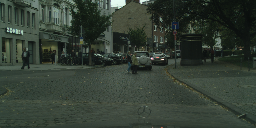

In [ ]:
img

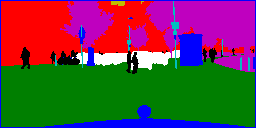

In [ ]:
generate_img_from_mask(create_mask(mask,cats),cats)

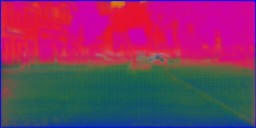

In [ ]:
generate_img_from_mask(model_unet.predict(img_norm.reshape(1,128,256,3))[0],cats)